In [1]:
# https://github.com/tuongv-1736461

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/pyshred-main')

Mounted at /content/drive


### SHRED applied to SST dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [2]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
from processdata import load_full_SST
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]

def run_shred(num_sensors, lags):
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    # We now select indices to divide the data into training, validation, and test sets.
    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask != 0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    # sklearn's MinMaxScaler is used to preprocess the data for training
    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    # Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    # Generate training, validation, and test datasets for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    # -1 to have output at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Train the model using the training and validation datasets
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)

    # Generate reconstructions from the test set and print mean square error compared to the ground truth
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    print("Test Error:", mse)

    # SST data with world map indices for plotting
    full_SST, sst_locs = load_full_SST()
    full_test_truth = full_SST[test_indices, :]

    # replacing SST data with our reconstruction
    full_test_recon = full_test_truth.copy()
    full_test_recon[:,sst_locs] = test_recons

    # reshaping to 2d frames
    for x in [full_test_truth, full_test_recon]:
        x.resize(len(x),180,360)
        
    return mse, full_test_recon, full_test_truth

epoch: 100 valid_error: tensor(0.2052): 100%|██████████| 100/100 [16:20<00:00,  9.80s/it]


Test Error: 0.034932088


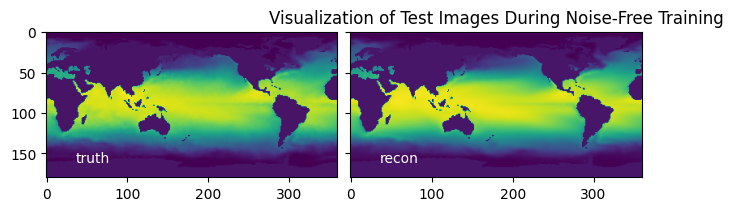

In [4]:
# Part 2 without added noise 
num_sensors = 3 
lags = 52
mse, recons, truth = run_shred(num_sensors, lags)

# Plot the recons vs truth 
plotdata = [truth, recons]
labels = ['truth','recon']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
plt.title('Visualization of Test Images During Noise-Free Training')
for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)

In [5]:
def run_shred2(num_sensors, lags):
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    # We now select indices to divide the data into training, validation, and test sets.
    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask != 0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    # sklearn's MinMaxScaler is used to preprocess the data for training
    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    # Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    # Generate training, validation, and test datasets for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    # -1 to have output at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Train the model using the training and validation datasets
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)

    # Generate reconstructions from the test set and print mean square error compared to the ground truth
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    print("Test Error:", mse)

    return mse

epoch: 100 valid_error: tensor(0.2025): 100%|██████████| 100/100 [16:45<00:00, 10.06s/it]


Test Error: 0.033900592


epoch: 100 valid_error: tensor(0.1955): 100%|██████████| 100/100 [16:05<00:00,  9.66s/it]


Test Error: 0.03510949


epoch: 100 valid_error: tensor(0.2141): 100%|██████████| 100/100 [16:12<00:00,  9.72s/it]


Test Error: 0.03604318


epoch: 100 valid_error: tensor(0.2108): 100%|██████████| 100/100 [16:06<00:00,  9.66s/it]


Test Error: 0.03547875


epoch: 100 valid_error: tensor(0.1948): 100%|██████████| 100/100 [16:25<00:00,  9.86s/it]


Test Error: 0.033275638


epoch: 100 valid_error: tensor(0.2092): 100%|██████████| 100/100 [15:45<00:00,  9.46s/it]


Test Error: 0.035380725


epoch: 100 valid_error: tensor(0.2030): 100%|██████████| 100/100 [16:08<00:00,  9.69s/it]


Test Error: 0.03526914


epoch: 100 valid_error: tensor(0.1948): 100%|██████████| 100/100 [15:53<00:00,  9.54s/it]


Test Error: 0.033576243


epoch: 100 valid_error: tensor(0.2041): 100%|██████████| 100/100 [15:58<00:00,  9.58s/it]


Test Error: 0.0344833


epoch: 100 valid_error: tensor(0.2162): 100%|██████████| 100/100 [16:27<00:00,  9.87s/it]


Test Error: 0.03614379


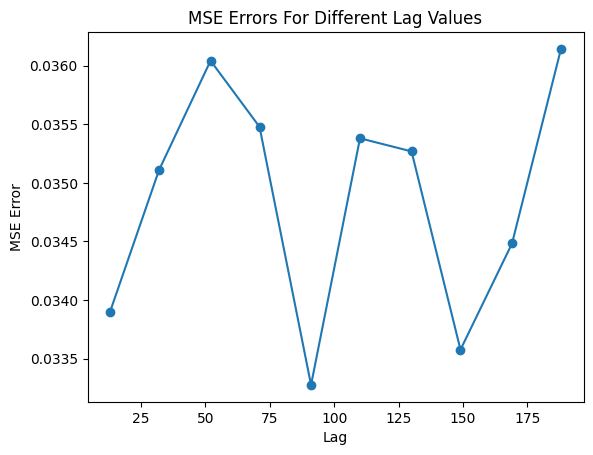

In [6]:
# Part 2 Performance as a function of the number of lags
# Define the list of lag values
lag_val = [13, 32, 52, 71, 91, 110, 130, 149, 169, 188]
num_sensors = 3 
mse_errors = []

for lag in lag_val:
    errors, mse = run_shred2(num_sensors, lags)
    mse_errors.append(mse)

# Plot MSE errors vs lags
plt.figure()
plt.plot(lag_val, mse_errors, marker='o')
plt.xlabel("Lag")
plt.ylabel("MSE Error")
plt.title("MSE Errors For Different Lag Values")
plt.show()

epoch: 100 valid_error: tensor(0.2350): 100%|██████████| 100/100 [16:23<00:00,  9.83s/it]


Test Error: 0.04473592


epoch: 100 valid_error: tensor(0.2059): 100%|██████████| 100/100 [15:53<00:00,  9.54s/it]


Test Error: 0.03458105


epoch: 100 valid_error: tensor(0.1879): 100%|██████████| 100/100 [15:47<00:00,  9.47s/it]


Test Error: 0.033294898


epoch: 100 valid_error: tensor(0.1735): 100%|██████████| 100/100 [15:50<00:00,  9.50s/it]


Test Error: 0.031954553


epoch: 100 valid_error: tensor(0.1807): 100%|██████████| 100/100 [15:40<00:00,  9.41s/it]


Test Error: 0.032056715


epoch: 100 valid_error: tensor(0.1743): 100%|██████████| 100/100 [15:55<00:00,  9.56s/it]


Test Error: 0.031571764


epoch: 100 valid_error: tensor(0.1699): 100%|██████████| 100/100 [15:23<00:00,  9.23s/it]


Test Error: 0.031143574


epoch: 100 valid_error: tensor(0.1685): 100%|██████████| 100/100 [15:59<00:00,  9.60s/it]


Test Error: 0.030656252


epoch: 100 valid_error: tensor(0.1649): 100%|██████████| 100/100 [15:54<00:00,  9.54s/it]


Test Error: 0.029974017


epoch: 100 valid_error: tensor(0.1634): 100%|██████████| 100/100 [16:07<00:00,  9.68s/it]


Test Error: 0.030500839


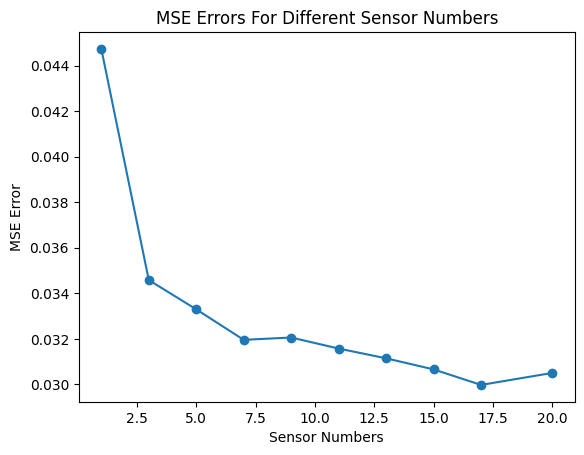

In [7]:
# Part 4 Performance as a function of the number of sensors
# Define the list of number of sensors
sensor_num = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20]
lag = 52
mse_errors = []

for num_sensors in sensor_num:
    errors, mse = run_shred2(num_sensors, lags)
    mse_errors.append(mse)

# Plot MSE errors vs sensor numbers
plt.figure()
plt.plot(sensor_num, mse_errors, marker='o')
plt.xlabel("Sensor Numbers")
plt.ylabel("MSE Error")
plt.title("MSE Errors For Different Sensor Numbers")
plt.show()

epoch: 100 valid_error: tensor(0.1862): 100%|██████████| 100/100 [07:40<00:00,  4.61s/it]


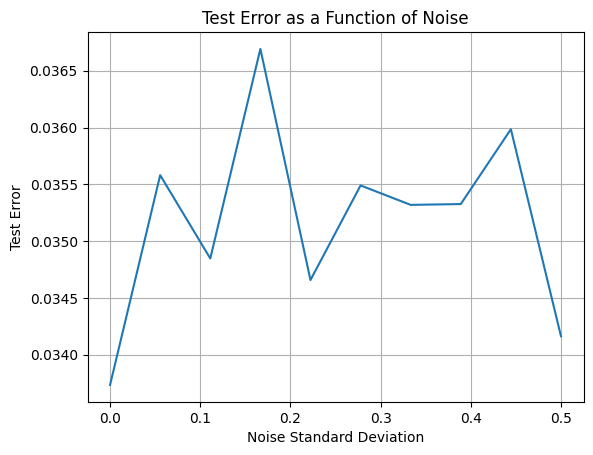

In [3]:
# Part 3 Training with added noise
num_sensors = 3
lags = 52
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

# Function to add Gaussian noise to data
def add_noise(data, mean=0, std=0.1):
    noise = np.random.normal(mean, std, size=data.shape)
    noisy_data = data + noise
    return noisy_data

# We now select indices to divide the data into training, validation, and test sets.
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask != 0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

# sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets.
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

# Generate input sequences to a SHRED model with Gaussian noise
noise_std_values = np.linspace(0, 0.5, num=10)  # Noise standard deviation values
test_errors = []

for noise_std in noise_std_values:
    noisy_data_in = add_noise(transformed_X, std=noise_std)
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = noisy_data_in[i:i + lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Train the model using the training and validation datasets
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)

    # Generate reconstructions from the test set
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    noise_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    test_errors.append(noise_error)

# Plotting the test error as a function of noise
plt.plot(noise_std_values, test_errors)
plt.xlabel('Noise Standard Deviation')
plt.ylabel('Test Error')
plt.title('Test Error as a Function of Noise')
plt.grid(True)
plt.show()


In [3]:
# Part 3 Training With added noise visualization 
num_sensors = 3
lags = 52
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

# Function to add Gaussian noise to data
def add_noise(data, mean=0, std=0.1):
    noise = np.random.normal(mean, std, size=data.shape)
    noisy_data = data + noise
    return noisy_data

# We now select indices to divide the data into training, validation, and test sets.
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask != 0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

# sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets.
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

noisy_data_in = add_noise(transformed_X, 0.1)
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = noisy_data_in[i:i + lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

# Train the model using the training and validation datasets
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)

# Generate reconstructions from the test set
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
noise_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
print("Test Error:", noise_error)

# SST data with world map indices for plotting
full_SST, sst_locs = load_full_SST()
full_test_truth = full_SST[test_indices, :]

# replacing SST data with our reconstruction
full_test_recon = full_test_truth.copy()
full_test_recon[:,sst_locs] = test_recons

# reshaping to 2d frames
for x in [full_test_truth, full_test_recon]:
    x.resize(len(x),180,360)


epoch: 100 valid_error: tensor(0.2099): 100%|██████████| 100/100 [16:39<00:00,  9.99s/it]


Test Error: 0.03486392


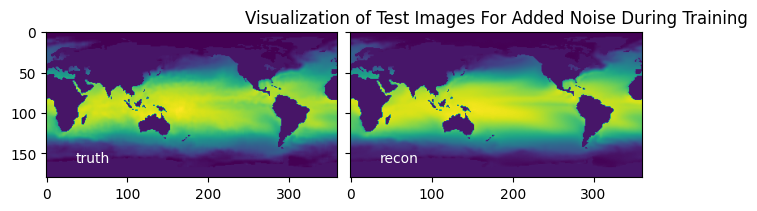

In [4]:
# Plot the recons vs truth 
plotdata = [full_test_truth, full_test_recon]
labels = ['truth','recon']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
plt.title('Visualization of Test Images For Added Noise During Training')
for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)
